In [66]:
import pandas as pd
import seaborn as sns
import pathlib as Path
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
import os
sns.set()
print(os.listdir("../input"))
import datetime as dt

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


## DATA LOAD

In [67]:
df_train = pd.read_csv('../input/train.csv', parse_dates=['pickup_datetime','dropoff_datetime'])
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## DATA EXPLORATION

In [68]:
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


## EDA

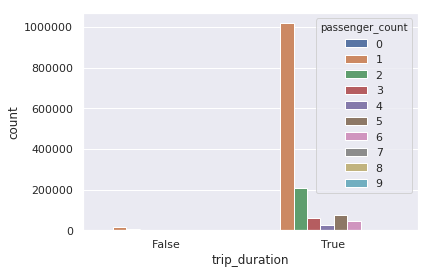

In [69]:
sns.countplot(x=df_train['trip_duration']<3000, hue=df_train['passenger_count'])

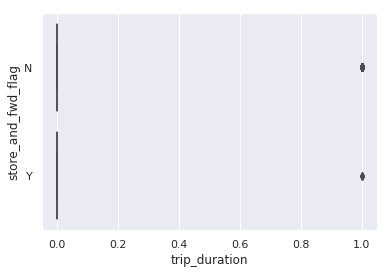

In [70]:
sns.boxplot(x=df_train['trip_duration']>7200, y=df_train["store_and_fwd_flag"])


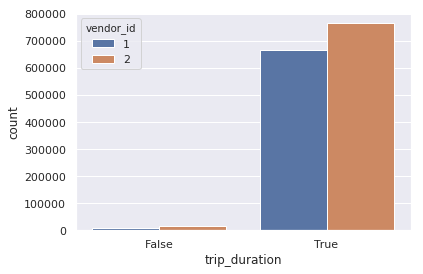

In [71]:
sns.countplot(x=df_train['trip_duration']<3000, hue=df_train['vendor_id'])

## FILTERING DATA

In [72]:
df_train[(df_train.trip_duration > 7000)].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594
1134,id1091477,2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.976280,40.750889,N,86149
1865,id3431345,2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,N,86352
3092,id0296060,2,2016-06-16 08:07:39,2016-06-16 10:11:39,2,-73.779083,40.647491,-74.006996,40.708523,N,7440
3442,id1487069,2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.968590,40.799217,-73.979584,40.784714,N,86236


**Commentaire:** on observe que certains trajets s'étendent sur plus d'une journée, il s'agit surement d'un bug donc:
   * on va filter sur la colonne "trip_duration" afin d'avoir une meilleure prédiction. 
   * On enlève les trajets sans passagers

In [73]:
df_train = df_train[(df_train.trip_duration < 7000)]
df_train = df_train[(df_train.passenger_count != 0)]
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## TRAIN SET FEATURE INGINEERING

**Extract data from date time **

In [74]:
def extract_datetime(df):
    df['pickup_year'] = df['pickup_datetime'].dt.year
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['pickup_day'] = df['pickup_datetime'].dt.day
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_minute'] = df['pickup_datetime'].dt.minute
    df['pickup_seconde'] = df['pickup_datetime'].dt.minute * 60
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    return df




In [75]:
selected_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                    'dropoff_latitude','pickup_year','pickup_month','pickup_day','pickup_hour','pickup_minute',
                    'pickup_seconde','pickup_weekday']


target='trip_duration'

extract_datetime(df_train)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_seconde,pickup_weekday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,14,17,24,1440,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,12,0,43,2580,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,19,11,35,2100,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,6,19,32,1920,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,26,13,30,1800,5
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,2016,1,30,22,1,60,5
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341,2016,6,17,22,34,2040,4
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551,2016,5,21,7,54,3240,5
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255,2016,5,27,23,12,720,4
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225,2016,3,10,21,45,2700,3


In [76]:

X_train = df_train[selected_columns]
y_train = df_train[target]
X_train.shape, y_train.shape

((1456315, 11), (1456315,))

## SPLIT THE DATA

In [77]:
rs = ShuffleSplit(n_splits=3, test_size=.12, train_size=.25)

## CROSS VALIDATION

In [78]:
rf = RandomForestRegressor(n_estimators=12, random_state=42)
losses = -cross_val_score(rf, X_train, y_train, cv=rs, scoring='neg_mean_squared_log_error')
losses = [np.sqrt(l) for l in losses]
np.mean(losses)

0.42598268757265023

## FIT DATA

In [79]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=12, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

## READ TEST SET

In [80]:
df_test = pd.read_csv('../input/test.csv',parse_dates=['pickup_datetime'])
extract_datetime(df_test)
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_seconde,pickup_weekday
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,2016,6,30,23,59,3540,3
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,2016,6,30,23,59,3540,3
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,2016,6,30,23,59,3540,3
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,2016,6,30,23,59,3540,3
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,2016,6,30,23,59,3540,3


 ##  TEST SET FEATURE INGINEERING

In [81]:
X_test = df_test[selected_columns]

## PREDICT

In [82]:
y_pred = rf.predict(X_test)
y_pred.mean()

846.7126664043233

## READ SUBMISSION FILE

In [83]:
submission = pd.read_csv('../input/sample_submission.csv') 
submission.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


In [84]:
submission['trip_duration'] = y_pred
submission.head()

,id,trip_duration
0,id3004672,805.583333
1,id3505355,624.916667
2,id1217141,427.833333
3,id2150126,1377.333333
4,id1598245,532.750000


In [85]:
submission.describe()

,trip_duration
count,625134.000000
mean,846.712666
std,594.767713
min,8.416667
25%,440.166667
50%,686.500000
75%,1068.666667
max,5834.750000


In [86]:
submission.to_csv('submission.csv', index=False)